<a href="https://colab.research.google.com/github/ninadcpa/dsc530/blob/main/Ninad_Patkhedkar_week5_exer_5_1_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Exercise 5.1 and 5.2

Author - Ninad Patkhedkar

In [1]:
from google.colab import drive
import sys
import os

# This code is to just use code checked out from github on google drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ThinkStats/ThinkStats2/code/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ThinkStats/ThinkStats2/code/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import nsfg
import first
import analytic

import thinkstats2
import thinkplot

## Exponential distribution

Here's what the exponential CDF looks like with a range of parameters.

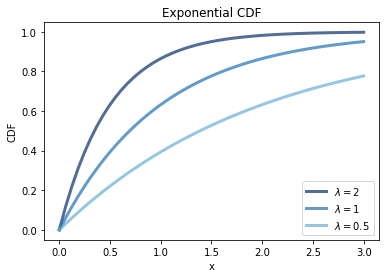

In [3]:
thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r'$\lambda=%g$' % lam
    thinkplot.Plot(xs, ps, label=label)
    
thinkplot.Config(title='Exponential CDF', xlabel='x', ylabel='CDF', 
                 loc='lower right')

Here's the distribution of interarrival times from a dataset of birth times.

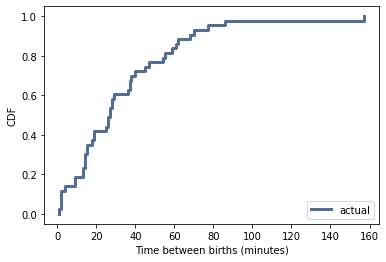

In [4]:
df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label='actual')

thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Time between births (minutes)', ylabel='CDF')

Here's what the CCDF looks like on a log-y scale.  A straight line is consistent with an exponential distribution.

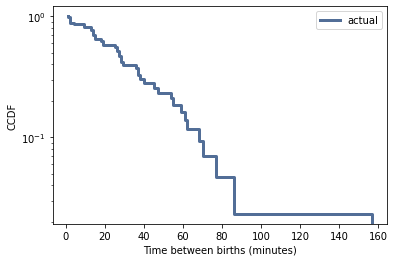

In [5]:
thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel='Time between births (minutes)',
                 ylabel='CCDF', yscale='log', loc='upper right')

## Normal distribution

Here's what the normal CDF looks like with a range of parameters.

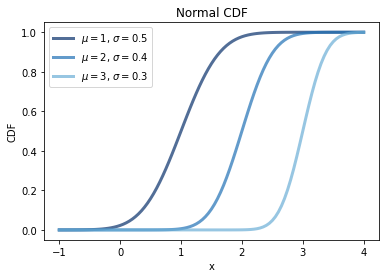

In [6]:
thinkplot.PrePlot(3)

mus = [1.0, 2.0, 3.0]
sigmas = [0.5, 0.4, 0.3]
for mu, sigma in zip(mus, sigmas):
    xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma, 
                                               low=-1.0, high=4.0)
    label = r'$\mu=%g$, $\sigma=%g$' % (mu, sigma)
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title='Normal CDF', xlabel='x', ylabel='CDF',
                 loc='upper left')

I'll use a normal model to fit the distribution of birth weights from the NSFG.

In [7]:
preg = nsfg.ReadFemPreg()
weights = preg.totalwgt_lb.dropna()

Here's the observed CDF and the model.  The model fits the data well except in the left tail.

Mean, Var 7.280883100022579 1.5452125703544897
Sigma 1.2430657948614343


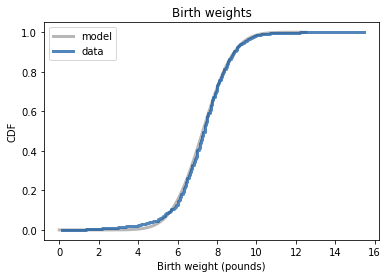

In [8]:
# estimate parameters: trimming outliers yields a better fit
mu, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
print('Mean, Var', mu, var)
    
# plot the model
sigma = np.sqrt(var)
print('Sigma', sigma)
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=12.5)

thinkplot.Plot(xs, ps, label='model', color='0.6')

# plot the data
cdf = thinkstats2.Cdf(weights, label='data')

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf) 
thinkplot.Config(title='Birth weights',
                 xlabel='Birth weight (pounds)',
                 ylabel='CDF')

A normal probability plot is a visual test for normality.  The following example shows that if the data are actually from a normal distribution, the plot is approximately straight.

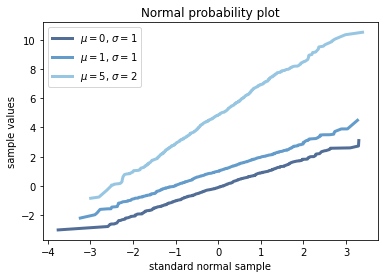

In [9]:
n = 1000
thinkplot.PrePlot(3) 

mus = [0, 1, 5]
sigmas = [1, 1, 2]

for mu, sigma in zip(mus, sigmas):
    sample = np.random.normal(mu, sigma, n)
    xs, ys = thinkstats2.NormalProbability(sample)
    label = '$\mu=%d$, $\sigma=%d$' % (mu, sigma)
    thinkplot.Plot(xs, ys, label=label)

thinkplot.Config(title='Normal probability plot',
                 xlabel='standard normal sample',
                 ylabel='sample values')

Here's the normal probability plot for birth weights, showing that the lightest babies are lighter than we expect from the normal mode, and the heaviest babies are heavier.

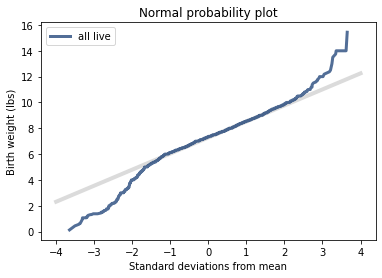

In [10]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = np.sqrt(var)

xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

xs, ys = thinkstats2.NormalProbability(weights)
thinkplot.Plot(xs, ys, label='all live')

thinkplot.Config(title='Normal probability plot',
                 xlabel='Standard deviations from mean',
                 ylabel='Birth weight (lbs)')

If we suspect that the deviation in the left tail is due to preterm babies, we can check by selecting only full term births.

In [11]:
full_term = preg[preg.prglngth >= 37]
term_weights = full_term.totalwgt_lb.dropna()

Now the deviation in the left tail is almost gone, but the heaviest babies are still heavy.

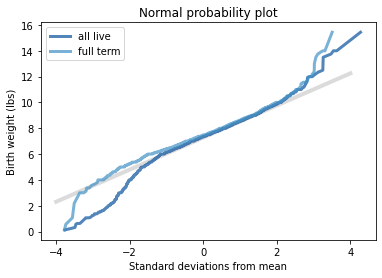

In [12]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = np.sqrt(var)

xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

thinkplot.PrePlot(2) 
xs, ys = thinkstats2.NormalProbability(weights)
thinkplot.Plot(xs, ys, label='all live')

xs, ys = thinkstats2.NormalProbability(term_weights)
thinkplot.Plot(xs, ys, label='full term')
thinkplot.Config(title='Normal probability plot',
                 xlabel='Standard deviations from mean',
                 ylabel='Birth weight (lbs)')

## Lognormal model

As an example of a lognormal disrtribution, we'll look at adult weights from the BRFSS.

In [13]:
import brfss
df = brfss.ReadBrfss()
weights = df.wtkg2.dropna()

The following function estimates the parameters of a normal distribution and plots the data and a normal model.

In [14]:
def MakeNormalModel(weights):
    """Plots a CDF with a Normal model.

    weights: sequence
    """
    cdf = thinkstats2.Cdf(weights, label='weights')

    mean, var = thinkstats2.TrimmedMeanVar(weights)
    std = np.sqrt(var)
    print('n, mean, std', len(weights), mean, std)

    xmin = mean - 4 * std
    xmax = mean + 4 * std

    xs, ps = thinkstats2.RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label='model', linewidth=4, color='0.8')
    thinkplot.Cdf(cdf)

Here's the distribution of adult weights and a normal model, which is not a very good fit.

n, mean, std 398484 78.59599565702814 17.754555191798524


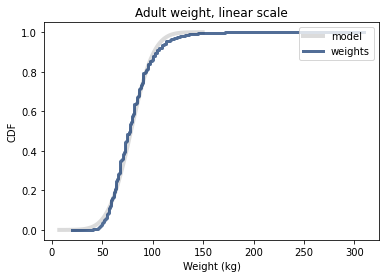

In [15]:
MakeNormalModel(weights)
thinkplot.Config(title='Adult weight, linear scale', xlabel='Weight (kg)',
                 ylabel='CDF', loc='upper right')

Here's the distribution of adult weight and a lognormal model, plotted on a log-x scale.  The model is a better fit for the data, although the heaviest people are heavier than the model expects.

n, mean, std 398484 1.884660713731975 0.0962358025915141


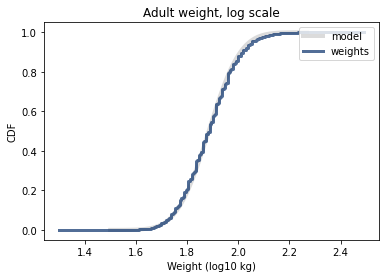

In [16]:
log_weights = np.log10(weights)
MakeNormalModel(log_weights)
thinkplot.Config(title='Adult weight, log scale', xlabel='Weight (log10 kg)',
                 ylabel='CDF', loc='upper right')

The following function generates a normal probability plot.

In [17]:
def MakeNormalPlot(weights):
    """Generates a normal probability plot of birth weights.

    weights: sequence
    """
    mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    std = np.sqrt(var)

    xs = [-5, 5]
    xs, ys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(xs, ys, color='0.8', label='model')

    xs, ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs, ys, label='weights')

When we generate a normal probability plot with adult weights, we can see clearly that the data deviate from the model systematically.

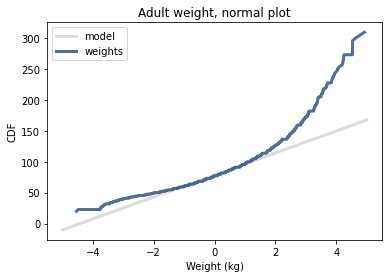

In [18]:
MakeNormalPlot(weights)
thinkplot.Config(title='Adult weight, normal plot', xlabel='Weight (kg)',
                 ylabel='CDF', loc='upper left')

If we make a normal probability plot with log weights, the model fit the data well except in the tails, where the heaviest people exceed expectations.

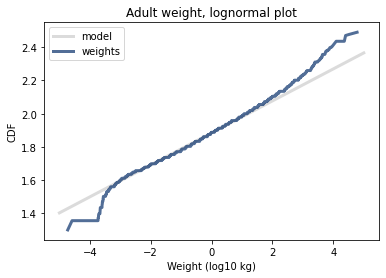

In [19]:
MakeNormalPlot(log_weights)
thinkplot.Config(title='Adult weight, lognormal plot', xlabel='Weight (log10 kg)',
                 ylabel='CDF', loc='upper left')

## Pareto distribution

Here's what the Pareto CDF looks like with a range of parameters.

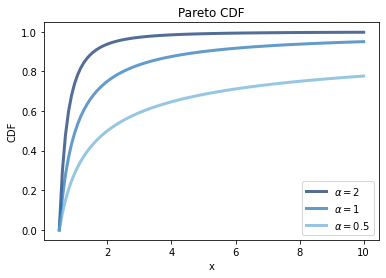

In [20]:
xmin = 0.5

thinkplot.PrePlot(3)
for alpha in [2.0, 1.0, 0.5]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100) 
    thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)
    
thinkplot.Config(title='Pareto CDF', xlabel='x',
                 ylabel='CDF', loc='lower right')

The distribution of populations for cities and towns is sometimes said to be Pareto-like.

In [21]:
import populations

pops = populations.ReadData()
print('Number of cities/towns', len(pops))

Number of cities/towns 19515


Here's the distribution of population for cities and towns in the U.S., along with a Pareto model.  The model fits the data well in the tail.

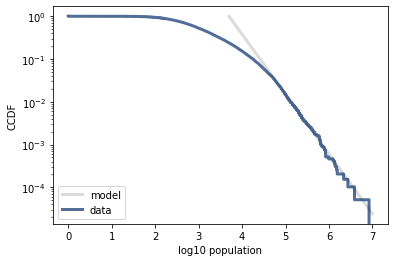

In [22]:
log_pops = np.log10(pops)
cdf = thinkstats2.Cdf(pops, label='data')
cdf_log = thinkstats2.Cdf(log_pops, label='data')

# pareto plot
xs, ys = thinkstats2.RenderParetoCdf(xmin=5000, alpha=1.4, low=0, high=1e7)
thinkplot.Plot(np.log10(xs), 1-ys, label='model', color='0.8')

thinkplot.Cdf(cdf_log, complement=True) 
thinkplot.Config(xlabel='log10 population',
                 ylabel='CCDF',
                 yscale='log', loc='lower left')

The lognormal model might be a better fit for this data (as is often the case for things that are supposed to be Pareto).

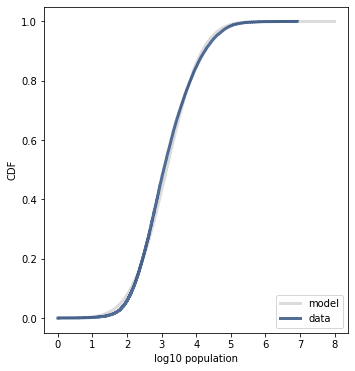

In [23]:
thinkplot.PrePlot(cols=2)

mu, sigma = log_pops.mean(), log_pops.std()
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=8)
thinkplot.Plot(xs, ps, label='model', color='0.8')

thinkplot.Cdf(cdf_log) 
thinkplot.Config(xlabel='log10 population',
                 ylabel='CDF', loc='lower right')

Here's a normal probability plot for the log-populations.  The model fits the data well except in the right tail, where the biggest cities are bigger than expected.

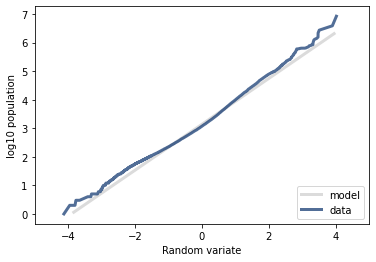

In [24]:
thinkstats2.NormalProbabilityPlot(log_pops, label='data')
thinkplot.Config(xlabel='Random variate',
                 ylabel='log10 population',
                 xlim=[-5, 5])

## Random variates

When we have an analytic CDF, we can sometimes invert it to generate random values.  The following function generates values from an exponential distribution.

In [25]:
import random

def expovariate(lam):
    p = random.random()
    x = -np.log(1-p) / lam
    return x

We can test it by generating a sample.

In [26]:
t = [expovariate(lam=2) for _ in range(1000)]

And plotting the CCDF on a log-y scale.

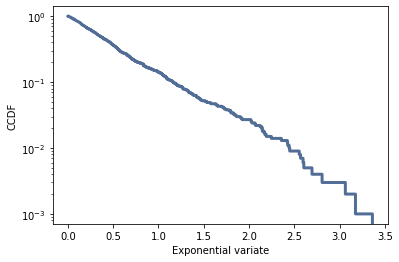

In [27]:
cdf = thinkstats2.Cdf(t)

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel='Exponential variate', ylabel='CCDF', yscale='log')

A straight line is consistent with an exponential distribution.

As an exercise, write a function that generates a Pareto variate.

## Exercises

**Exercise 5.1:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [1]:
import scipy.stats

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [2]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

A "frozen random variable" can compute its mean and standard deviation.

In [3]:
dist.mean(), dist.std()

(178.0, 7.7)

It can also evaluate its CDF.  How many people are more than one standard deviation below the mean?  About 16%

In [4]:
dist.cdf(mu-sigma)

0.1586552539314574

How many people are between 5'10" and 6'1"?

In [32]:
low = dist.cdf(177.8)    # 5'10"
high = dist.cdf(185.4)   # 6'1"
low, high, high-low

(0.48963902786483265, 0.8317337108107857, 0.3420946829459531)

**Exercise 5.2:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [33]:
alpha = 1.7
xmin = 1       # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

What is the mean height in Pareto world?

In [34]:
dist.mean()

2.428571428571429

What fraction of people are shorter than the mean?

In [35]:
dist.cdf(dist.mean())

0.778739697565288

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [36]:
(1 - dist.cdf(1000)) * 7e9, dist.sf(1000) * 7e9

(55602.976430479954, 55602.97643069972)

How tall do we expect the tallest person to be?

In [37]:
# One way to solve this is to search for a height that we
# expect one person out of 7 billion to exceed.

# It comes in at roughly 600 kilometers.

dist.sf(600000) * 7e9            

1.0525455861201714

In [38]:
# Another way is to use `ppf`, which evaluates the "percent point function", which
# is the inverse CDF.  So we can compute the height in meters that corresponds to
# the probability (1 - 1/7e9).

dist.ppf(1 - 1/7e9)

618349.6106759505